# Example: Mixed-Element Mesh for Delineated Watershed

This workflow provides a part of worlflow to develop an streamaligned mixed-element mesh for Taylor upstream watershed. Long quad elements with pentagons at junctions are placed along NHDPlus flowlines to represent rivers/streams. Rest of the domain is meshed with standard TIN. This example has internal huc boundaries that are modified to accomodate river corridor. This workflow only shows steps to get a terrain following 2D surface mesh. Rest of the steps are same as other examples

It uses the following datasets:

* `NHD Plus` for the watershed boundary and hydrography.
* `NED` for elevation

In [14]:
## Importing all the package needed to run teh watershed workflow
# conda package imports
import numpy as np
from matplotlib import pyplot as plt
import logging
import pandas as pd
import copy
import shapely

import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.regions
import watershed_workflow.densification
import watershed_workflow.condition
watershed_workflow.ui.setup_logging(1,None)

In [ ]:
# silence shapely2.0 and crs WKT warnings
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed.
name = 'Taylor_Upstream' # name the domain, used in filenames, etc
hucs = ['140200010101','140200010102','140200010103'] # a list of HUCs to run
huc_level = 12 # if provided, an int setting the level at which to include HUC boundaries
modis_name = None

# geometric parameters
simplify = 100 # length scale to target average edge
simplify_rivers = 100
stream_outlet_width = 500 # half-width to track a labeled set on which to get discharge
ignore_small_rivers = 2 # ignore rivers which have this or fewer reaches.  likely they are irrigation ditches
                        # or other small features which make things complicated but likely don't add much value
prune_by_area_fraction = 0.02 # ignore reaches whose accumulated catchment area is less than this fraction of the
                              # full domain's area
prune_by_area_fraction_waterbodies = None
num_smoothing_sweeps = 5 # number of times to smooth the DEM prior to elevating

# simulation control
start_year = 1980  # year to start and end simulation simulation -- note these start and end Oct 1 of the year
end_year = 2020
min_porosity = 0.05 # minimum porosity considered too small
max_permeability = 1.e-10 # max value allowed for permeability
max_vg_alpha = 1.e-3 # max value of van Genuchten's alpha -- our correlation is not valid for some soils

# triangle refinement control
include_rivers = True
refine_d0 = 100
refine_d1 = 500
refine_A0 = 8000
refine_A1 = 50000

# soil structure
use_geologic_layer = True

# logistics
generate_plots = True # plots take time to make and aren't always needed
generate_daymet = True # potentially don't do Met data forcing
generate_modis = True

include_heterogeneous = True
include_homogeneous = False # if true, also write files for homogeneous runs
include_homogeneous_wrm = False # if true, also write files for homogeneous WRMs
include_homogeneous_wrm_porosity = False # if true, also write files for homogeneous porosity and WRMs
include_homogeneous_wrm_permeability = False # if true, also write files for homogeneous perm and WRMs

log_to_file = False  # if true, write to file instead of in the notebook output
figsize = (6,6)
figsize_3d = (8,6)

In [16]:
# parameter checking
assert(simplify > 0 and simplify < 300)
assert(ignore_small_rivers == None or (ignore_small_rivers >= 0 and ignore_small_rivers <= 100))
assert(prune_by_area_fraction == None or (prune_by_area_fraction >= 0 and prune_by_area_fraction < 1))
assert(start_year >= 1980 and start_year < 2020)

if type(hucs) is str:
    assert(hucs[0] == '[')
    assert(hucs[-1] == ']')
    hucs = hucs[1:-1]
    hucs = hucs.split(',')
    hucs = [h.strip() for h in hucs]
    if hucs[-1] == '':
        hucs = hucs[:-1]

if huc_level is None:
    huc_level = len(hucs[0])
else:
    assert(huc_level >= len(hucs[0]))
huc_key = f'HUC{huc_level}'

if prune_by_area_fraction_waterbodies is None:
    prune_by_area_fraction_waterbodies = prune_by_area_fraction * 0.1


In [17]:
# a dictionary of outputs -- will include all filenames generated
outputs = {}

In [18]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs()

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [19]:
logging.info("")
logging.info(f"Meshing shape: {hucs}")
logging.info("="*30)


2023-12-10 10:34:24,090 - root - INFO: 
2023-12-10 10:34:24,091 - root - INFO: Meshing shape: ['140200010101', '140200010102', '140200010103']
2023-12-10 10:34:24,091 - root - INFO: ==============================


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [20]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = watershed_workflow.source_list.huc_sources['NHD Plus']
sources['DEM'] = watershed_workflow.source_list.dem_sources['NED 1/3 arc-second']
watershed_workflow.source_list.log_sources(sources)

2023-12-10 10:34:24,095 - root - INFO: Using sources:
2023-12-10 10:34:24,096 - root - INFO: --------------
2023-12-10 10:34:24,096 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2023-12-10 10:34:24,096 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2023-12-10 10:34:24,096 - root - INFO: DEM: National Elevation Dataset (NED)
2023-12-10 10:34:24,096 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2023-12-10 10:34:24,097 - root - INFO: geologic structure: GLHYMPS version 2.0
2023-12-10 10:34:24,097 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2019_Land_Cover_L48
2023-12-10 10:34:24,097 - root - INFO: lai: MODIS
2023-12-10 10:34:24,097 - root - INFO: soil thickness: None
2023-12-10 10:34:24,098 - root - INFO: meteorology: DayMet 1km


In [21]:
# # load the huc
# my_hucs = []
# for huc in hucs:
#     _, ws = watershed_workflow.get_hucs(sources['HUC'], huc, huc_level, crs)
#     my_hucs.extend(ws)

# watershed = watershed_workflow.split_hucs.SplitHUCs(my_hucs)

## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

### Get river network

This will download the river network from the NHD Plus database, and simplify the network, constructing a tree-like data structure.

While constructing river, user should be intetntional with prune options to get desired river network density. It is recommended to not have too dense river network if not needed as each reach in the river tree will show up in quad mesh

In [22]:
# include_rivers=True

# if include_rivers:  
#     # download/collect the river network within that shape's bounds
#     _, reaches = watershed_workflow.get_reaches(sources['hydrography'], "1402", 
#                                                 watershed.exterior(), crs, crs,
#                                                 in_network=True, properties=True)
    
#     rivers = watershed_workflow.construct_rivers(reaches, method='hydroseq',
#                                                  ignore_small_rivers=ignore_small_rivers,
#                                                  prune_by_area=prune_by_area_fraction*watershed.exterior().area*1e-6,
#                                                  remove_diversions=True,
#                                                  remove_braided_divergences=True)

This watershed has three subwatersheds. The internal watershed boundaries will be accomodated in the river mesh

In [23]:
# import pickle
# with open("./data/pickled_data/taylor_upstream_rivers", 'wb') as handle:
#     pickle.dump(rivers, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open("./data/pickled_data/taylor_upstream_rivers_watershed", 'wb') as handle:
#     pickle.dump(watershed, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
# load pickle files of already created rivers
import pickle
with open("./data/pickled_data/taylor_upstream_rivers", 'rb') as handle:
    rivers = pickle.load(handle)

In [25]:
# load pickle files of already created rivers
import pickle
with open("./data/pickled_data/taylor_upstream_rivers_watershed", 'rb') as handle:
    watershed = pickle.load(handle)

/Users/7s2/opt/anaconda3/envs/watershed_workflow-2023-sep/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


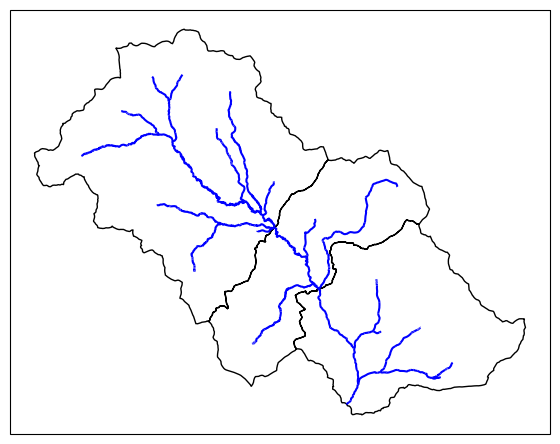

In [26]:
if generate_plots:
    fig = plt.figure(figsize=figsize)
    ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])    
    watershed_workflow.plot.hucs(watershed, crs, 'k', ax)
    watershed_workflow.plot.rivers(rivers, crs, 'b', ax)
    plt.show()

In the simplification step below, we keep the original river so that we can sample vertices from these original dense rivers and huc boundaries to get vertex density at desired resolution.

Using the Douglas-Peucker algorithm, we simplify the flowline by removing non-essential vertices with shapely's "simplify" method, ensuring accurate representation. Additional simplifications, such as merging minor reaches and aligning watershed boundaries with flowlines, are also performed. 

TIPS:
- keep merge tolerance about 70% of the simplify_rivers tolerance
- use smaller snap tolerance (50% of simplify_rivers) if non-outlet reaches start snapping to the watershed boundaries

In [27]:
# keeping the originals
rivers_orig=[river.deepcopy() for river in rivers]
watershed_orig=copy.deepcopy(watershed) 

# simplifying 
rivers = watershed_workflow.simplify(watershed, rivers, simplify_hucs=150, simplify_rivers=80, snap_tol = 30, merge_tol=50, cut_intersections=True)

# for plotting purpose only
rivers_simplified=[river.deepcopy() for river in rivers] 
watershed_simplified=copy.deepcopy(watershed) 

print('number of reaches in original', len(rivers_orig[0]), 'number of reaches in simplified', len(rivers[0]))

2023-12-10 10:34:37,354 - root - INFO: 
2023-12-10 10:34:37,354 - root - INFO: Simplifying
2023-12-10 10:34:37,354 - root - INFO: ------------------------------
2023-12-10 10:34:37,355 - root - INFO: Simplifying rivers
2023-12-10 10:34:37,381 - root - INFO:   ...cleaned inner segment of length 27.3949 at centroid (-550066.6557169502, -354182.56026820093) with id '41000700007957'
2023-12-10 10:34:37,383 - root - INFO:   ...cleaned inner segment of length 32.1434 at centroid (-550275.8704613056, -354113.3198040555) with id '41000700034678'
2023-12-10 10:34:37,384 - root - INFO:   ...cleaned inner segment of length 13.5218 at centroid (-550817.0960034213, -354102.9226821841) with id '41000700007881'
2023-12-10 10:34:37,385 - root - INFO:   ...cleaned inner segment of length 10.3474 at centroid (-550826.6341381434, -354110.0018943842) with id '41000700052354'
2023-12-10 10:34:37,387 - root - INFO:   ...cleaned inner segment of length 27.0633 at centroid (-550838.9702706095, -354123.6162809

number of reaches in original 317 number of reaches in simplified 181


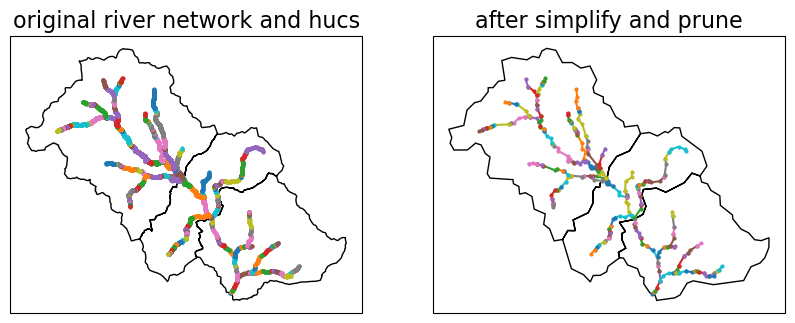

In [28]:
plt.rcParams['figure.figsize'] = [10, 10]
watershed_workflow.ui.setup_logging(1,None)

fig, axs = plt.subplots(1,2,subplot_kw={'projection':watershed_workflow.crs.to_cartopy(crs)})
watershed_workflow.plot.hucs(watershed_orig, crs, 'k', axs[0])
axs[0].set_title('original river network and hucs',fontsize=16)
watershed_workflow.plot.hucs(watershed, crs, 'k', axs[1])
axs[1].set_title('after simplify and prune',fontsize=16)

for river in rivers_orig:

    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[0].plot(x,y,'-o',markersize=2)

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[1].plot(x,y,'-o',markersize=2)
        
plt.show()

In step two, we enhance the flowline's resolution by adding nearly uniformly distributed vertices, sampled from the original to regain any curvature lost during simplification, with an upper user-defined limit dictating the distance between consecutive vertices, ultimately determining the quad length in the river mesh. When the distance in a reach segment, represented as a shapely.LineString object, surpasses this scale, additional vertices are inserted, their number and coordinates derived using 1D interpolation from the original segment vertices. 

The limit of distance between vertices on the huc boundary is a function of distance from the river. Parts of huc segments close to river get vertices placd at higher density. 

Sharp bends in the river and tributaries running closely before merging are a couple of cases that can constrain triangulation to yield small triangles. Hence, we smoothen out some of these sharp angles

TIPS:

- provide L0 about same as length scale limit on river and  L1 about 1.5 to 2 times times length scale limit on river
- profile d1 atleast equal to length scale limit on river

In [29]:
d0 = 20; d1 = 100
L0 = 100; L1 = 250

# densify_watershed
watershed_workflow.densification.densify_hucs(watershed, watershed_orig, rivers, limit_scales=[d0,L0,d1,L1]) 

#densify_river
watershed_workflow.densification.densify_rivers(rivers, rivers_orig, limit=120)

# treat sharp angles
watershed_workflow.densification.remove_sharp_angles(rivers, watershed, angle_limit=30, junction_angle_limit=20, huc_seg_river_angle_limit=25, limit=120)

2023-12-10 10:34:43,652 - root - INFO:   river min seg length: 51.644597373587295
2023-12-10 10:34:43,653 - root - INFO:   river median seg length: 91.30374010994977
2023-12-10 10:34:44,157 - root - INFO: removing sharp angle: 19.20108676431292
2023-12-10 10:34:44,164 - root - INFO: removing sharp angle: -10.766762422936893
2023-12-10 10:34:44,165 - root - INFO:   ...cleaned inner segment of length 70.8243 at centroid (-553537.1162569833, -356651.597277535) with id '41000700070061'
2023-12-10 10:34:44,165 - root - INFO:   ...cleaned inner segment of length 61.0739 at centroid (-552622.0279682197, -353697.4481052715) with id '41000700034515'
2023-12-10 10:34:44,166 - root - INFO:   ...cleaned inner segment of length 51.6446 at centroid (-551942.7688315129, -349376.44300159655) with id '41000700070165'
2023-12-10 10:34:44,167 - root - INFO:   ...cleaned inner segment of length 60.2195 at centroid (-555700.2963535548, -348792.16569931747) with id '41000700043200'


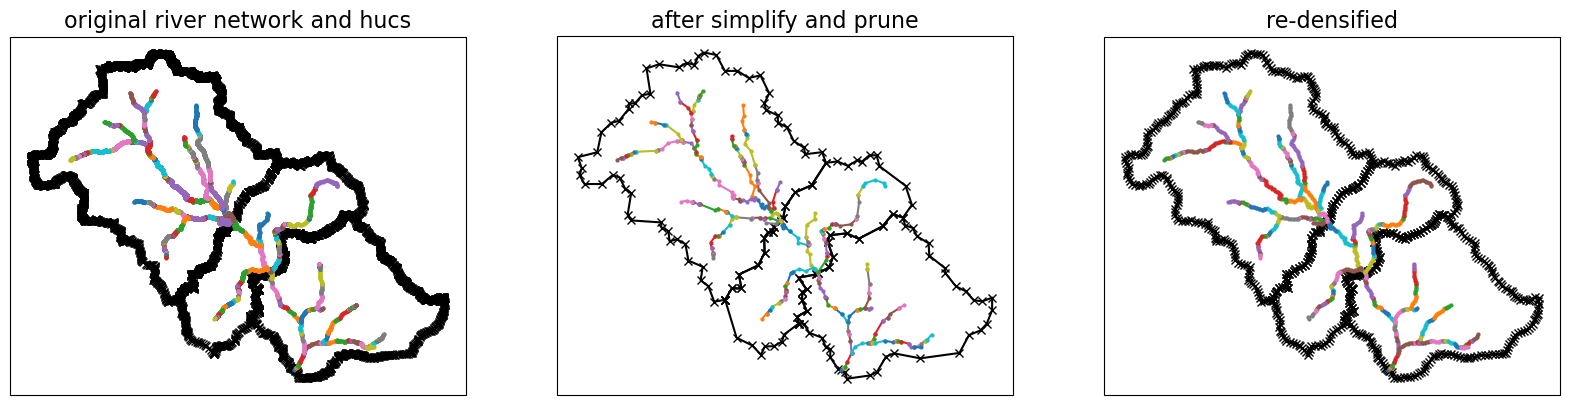

In [30]:
# plotting results
plt.rcParams['figure.figsize'] = [20, 12]

fig, axs = plt.subplots(1,3,subplot_kw={'projection':watershed_workflow.crs.to_cartopy(crs)})

for huc in list(watershed_orig.polygons()):
    axs[0].plot(huc.exterior.xy[0], huc.exterior.xy[1], 'k-x')
axs[0].set_title('original river network and hucs',fontsize=16)
for huc in list(watershed_simplified.polygons()):
    axs[1].plot(huc.exterior.xy[0], huc.exterior.xy[1], 'k-x')
axs[1].set_title('after simplify and prune',fontsize=16)
for huc in list(watershed.polygons()):
    axs[2].plot(huc.exterior.xy[0], huc.exterior.xy[1], 'k-x')
axs[2].set_title('re-densified',fontsize=16)
axs[2].plot()

for river in rivers_orig:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[0].plot(x,y,'-o',markersize=2)

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[1].plot(x,y,'-o',markersize=2)

for river in rivers:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[2].plot(x,y,'-o',markersize=2)
plt.show()

In [31]:
# how many types of Stream Orders are there
set([r.properties["StreamOrder"] for r in rivers[0].preOrder()])

{2, 3, 4, 5}

Widths in the river corridor mesh (quads) is given through dictionary of Stream Order:Width. One way to get these values is to do a quick survey on GIS map and see for the given watershed, what are typical widths of different stream orders. Or, user may also provide width as a function of drainage area. 

2023-12-10 10:34:54,649 - root - INFO: 
2023-12-10 10:34:54,650 - root - INFO: Stream-aligned Meshing
2023-12-10 10:34:54,650 - root - INFO: ------------------------------
2023-12-10 10:34:54,651 - root - INFO: Creating stream-aligned mesh...
2023-12-10 10:34:54,651 - root - INFO: River 0
2023-12-10 10:34:54,652 - root - INFO: ... generating initial polygon through dilation (4 m)
2023-12-10 10:34:54,661 - root - INFO:   -- treating collinearity
2023-12-10 10:34:54,672 - root - INFO:   -- river min seg length: 57.9894747905088
2023-12-10 10:34:54,673 - root - INFO:   -- merging points closer than 41.9894747905088 m along the river corridor
2023-12-10 10:34:54,687 - root - INFO: ... defining river-mesh topology (quad elements)
2023-12-10 10:34:54,751 - root - INFO: ... setting width of quad elements
2023-12-10 10:34:54,762 - root - INFO: ... enforcing convexity
2023-12-10 10:34:54,768 - root - INFO: Adjusting rivers at the watershed boundaries...
2023-12-10 10:34:54,769 - root - INFO:   

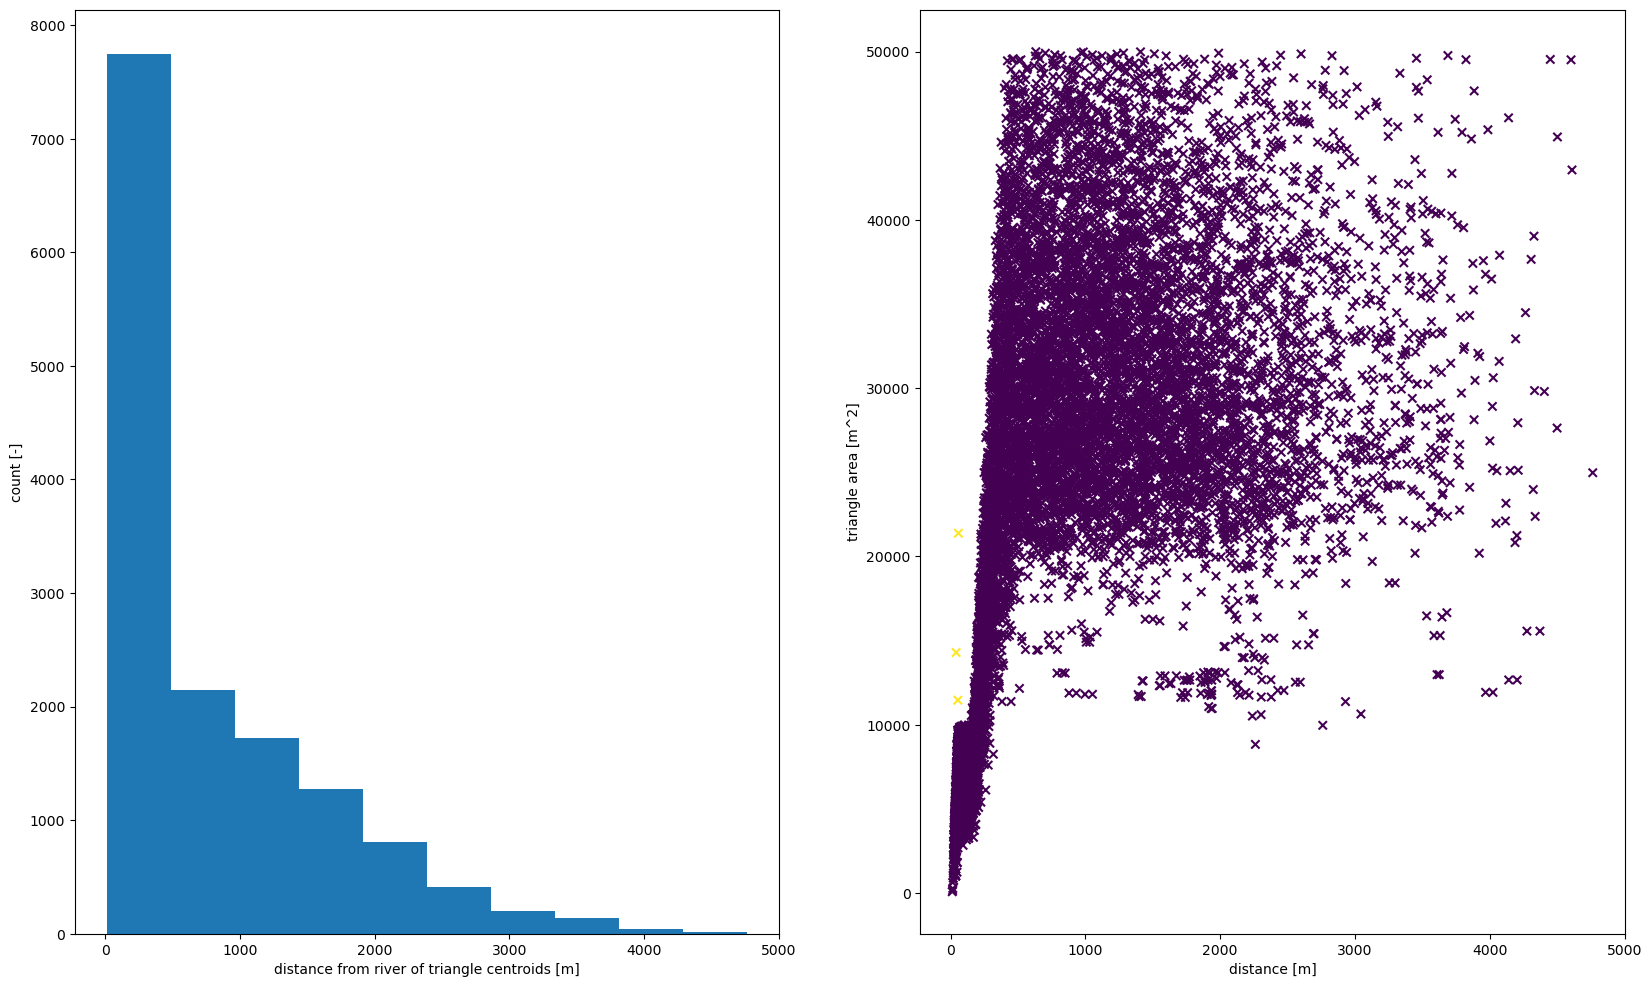

In [32]:
## Triangulation

refine_d0 = 150 
refine_d1 = 400
refine_A0 = 10000
refine_A1 = 50000

d0 = refine_d0; d1 = refine_d1
A0 = refine_A0; A1 = refine_A1 

# Refine triangles if they get too acute
min_angle = 20 # degrees

# width of reach by stream order (order:width)
widths = dict({2:10,3:20,4:30,5:30}) 

mesh_points2, conn_list, areas, dists = watershed_workflow.tessalate_river_aligned(watershed,rivers, river_width=widths,
                                              refine_min_angle=min_angle,refine_distance=[d0,A0,d1,A1],
                                              diagnostics=True)

In [33]:
# get a raster for the elevation map, based on NED
dem_profile, dem = watershed_workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

# elevate the triangle nodes to the dem
mesh_points3 = watershed_workflow.elevate(mesh_points2, crs, dem, dem_profile)

2023-12-10 10:36:52,622 - root - INFO: 
2023-12-10 10:36:52,622 - root - INFO: Loading Raster
2023-12-10 10:36:52,623 - root - INFO: ------------------------------
2023-12-10 10:36:52,624 - root - INFO: Collecting raster
2023-12-10 10:36:52,631 - root - INFO: Collecting DEMs to tile bounds: [-106.81032954674818, 38.84352861677489, -106.43888797230935, 39.06593763312742]
2023-12-10 10:36:52,632 - root - INFO:   Need:
2023-12-10 10:36:52,632 - root - INFO:     /Users/7s2/Research/watershed_workflow_data/dem/USGS_NED_13as_n39_w107.tif
2023-12-10 10:36:52,632 - root - INFO:     /Users/7s2/Research/watershed_workflow_data/dem/USGS_NED_13as_n40_w107.tif
2023-12-10 10:36:52,633 - root - INFO: source files already exist!
2023-12-10 10:36:53,007 - root - INFO: ... got raster of shape: (2402, 4012)
2023-12-10 10:36:53,008 - root - INFO: ... got raster bounds: (-106.81032954674818, 39.06593763312742, -106.43884806486706, 38.84353022528096)


In [34]:
# construct the 2D mesh
m2 = watershed_workflow.mesh.Mesh2D(mesh_points3.copy(), conn_list)

In [35]:
shapes = [shapely.geometry.Polygon(m2.coords[c, :]) for c in m2.conn]
area = np.array([shp.area for shp in shapes])
small = np.where(area < 500)[0]
centroids = m2.centroids

In [39]:
domain_colors = watershed_workflow.colors.enumerated_colors(len(list(watershed.polygons())), 1)

/Users/7s2/opt/anaconda3/envs/watershed_workflow-2023-sep/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'cmap': 'terrain', 'facecolor': 'none'}
setting face color =  [3088.7469370040167, 3633.6340756294517, 2876.1558832888745, 3591.0333518788343, 3600.0361355860914, 2931.336647165939, 3468.5584722380404, 3576.9031811851005, 3642.0077364138947, 3271.6478170296155, 3569.248206448929, 3561.8459872611493, 3602.3234442312732, 3035.900985761468, 3253.0355755426294, 3561.3479333897562, 3447.6074593449853, 3294.8099265727906, 3494.4292648640553, 2916.911253686296, 2865.990865038744, 3352.6197905338645, 3439.4427888964606, 3109.1410715220086, 3102.295276183501, 2931.3850257972463, 3475.551665342158, 3030.1894156891053, 3464.919430910993, 3446.748797291766, 3373.8300699414262, 3484.8616351494234, 3275.1777558955523, 3316.4263113753805, 3272.944502778308, 2964.3801534273302, 3278.2710009855746, 3289.213939051568, 3263.320644474501, 3352.3048155674746, 3595.2774661093986, 3397.7744640515884, 3629.32559677561, 2973.6139294521868, 3275.5278308932743, 3222.3659918327417, 3286.3169995463563, 

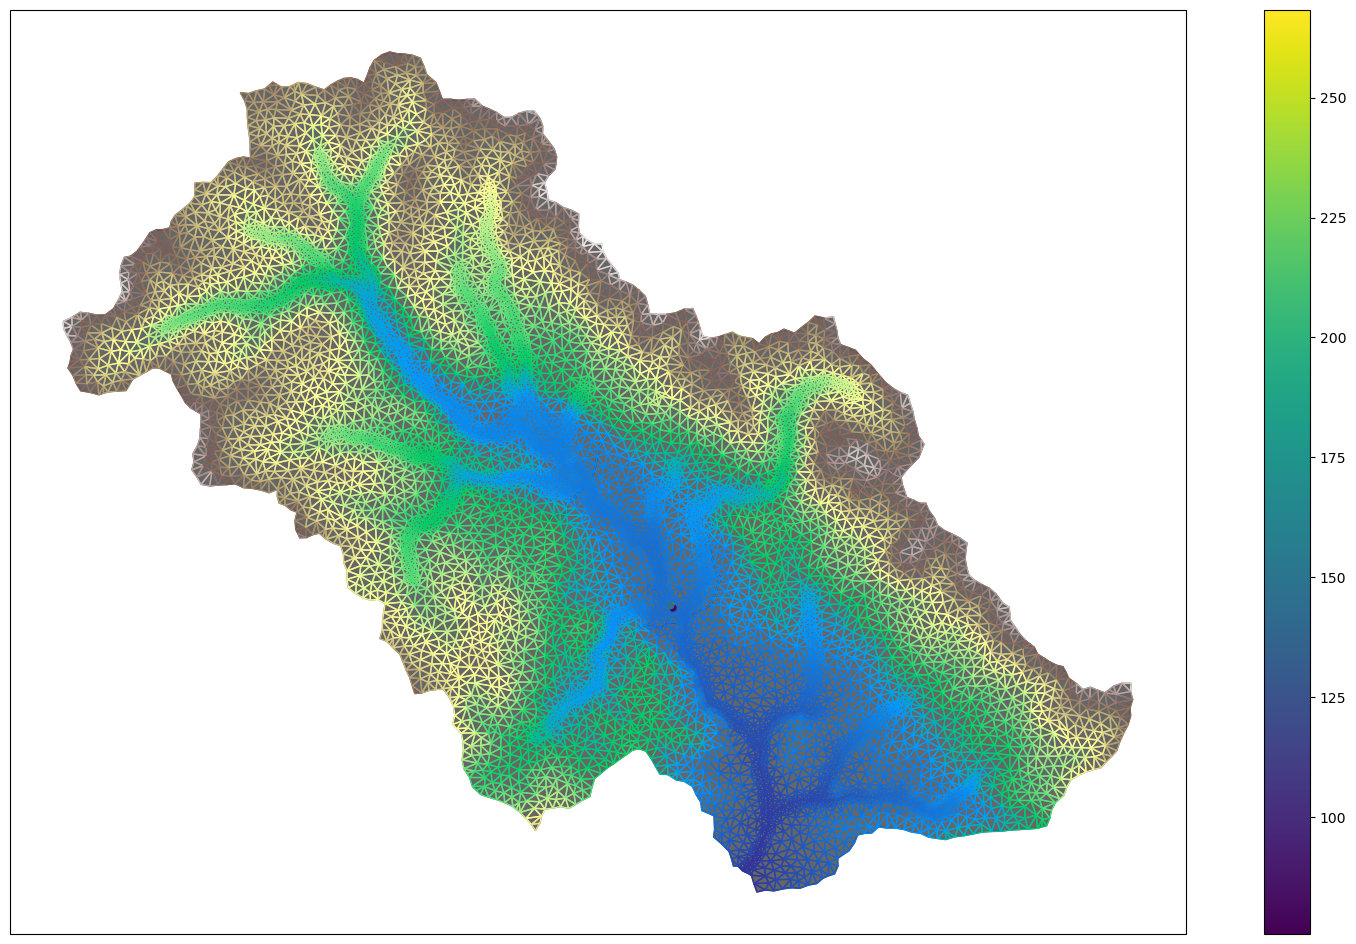

In [41]:
fig, ax = watershed_workflow.plot.get_ax(crs)

watershed_workflow.plot.hucs(watershed, crs=crs,  ax=ax, facecolor='edge', alpha=0.6)
im = watershed_workflow.plot.shplys(shapes, crs, 'elevation', ax, cmap='terrain')
sc = ax.scatter(centroids[small,0], centroids[small,1], c=area[small], marker='o', s=20)
plt.colorbar(sc)
plt.show()


In the pit-filling algorithm, we want to make sure that river corridor is not filled up. Hence we exclude river corridor cells from the pit-filling algorithm.

In [42]:
# find outlet
watershed_workflow.split_hucs.find_outlets_by_crossings(watershed, rivers[0])

2023-12-10 10:39:45,855 - root - INFO: Crossings by Polygon:
2023-12-10 10:39:45,855 - root - INFO:   Polygon 0
2023-12-10 10:39:45,856 - root - INFO:     crossing: [-548906.6040392  -354307.32954107]
2023-12-10 10:39:45,856 - root - INFO:   Polygon 1
2023-12-10 10:39:45,856 - root - INFO:     crossing: [-548906.6040392  -354307.32954107]
2023-12-10 10:39:45,857 - root - INFO:     crossing: [-546328.8022804  -357918.47563459]
2023-12-10 10:39:45,857 - root - INFO:   Polygon 2
2023-12-10 10:39:45,857 - root - INFO:     crossing: [-544745.24137562 -364572.43161528]
2023-12-10 10:39:45,858 - root - INFO:     crossing: [-546328.8022804  -357918.47563459]
2023-12-10 10:39:45,858 - root - INFO: Constructing outlet list
2023-12-10 10:39:45,859 - root - INFO: Iteration = 0
2023-12-10 10:39:45,859 - root - INFO: -----------------
2023-12-10 10:39:45,859 - root - INFO:  poly outlet 0 : 0, [-548906.6040392  -354307.32954107]
2023-12-10 10:39:45,860 - root - INFO:  poly inlet 1 : 0, [-548906.60403

In [43]:
# add labeled sets for subcatchments and outlets
watershed_workflow.regions.add_watershed_regions_and_outlets(m2, watershed, outlet_width=stream_outlet_width, 
                                                          labels=[p.properties[huc_key] for p in watershed.polygons()], exterior_outlet= True)

# add labeled sets for river corridor cells
watershed_workflow.regions.add_river_corridor_regions(m2, rivers)


# add labeled sets for river corridor cells by order
watershed_workflow.regions.add_regions_by_stream_order_rivers(m2, rivers, labels=None)

In [44]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

10000 : CELL : 7655 : "140200010101"
10001 : CELL : 7655 : "140200010101 surface"
10002 : CELL : 3627 : "140200010102"
10003 : CELL : 3627 : "140200010102 surface"
10004 : CELL : 4161 : "140200010103"
10005 : CELL : 4161 : "140200010103 surface"
10006 : FACE : 308 : "140200010101 boundary"
10007 : FACE : 0 : "140200010101 outlet"
10008 : FACE : 247 : "140200010102 boundary"
10009 : FACE : 0 : "140200010102 outlet"
10010 : FACE : 233 : "140200010103 boundary"
10011 : FACE : 0 : "140200010103 outlet"
10012 : FACE : 0 : "surface domain outlet"
10013 : CELL : 936 : "river_corridor 0 surface"
10014 : CELL : 220 : "reaches of StreamOrder 5 in river 0 surface"
10015 : CELL : 201 : "reaches of StreamOrder 4 in river 0 surface"
10016 : CELL : 481 : "reaches of StreamOrder 3 in river 0 surface"
10017 : CELL : 34 : "reaches of StreamOrder 2 in river 0 surface"
